**Lab 4**

Problem 1

1)
We are going to be looking at a large dataset this week of 25 million rows
lets first import it

In [151]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import math
from scipy import optimize

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,3)

In [152]:
hf = h5py.File('gammaray_lab4.h5', 'r')


In [153]:
hf.keys()

<KeysViewHDF5 ['data']>

In [154]:
data = np.array(hf.get('data'))
data[1]

array([315.        , 315.00711228, 315.01422457, ..., 345.31910877,
       345.32622105, 345.33333333])

In [155]:
hf.close

<bound method File.close of <HDF5 file "gammaray_lab4.h5" (mode r)>>

In [156]:
Data = pd.DataFrame({'time':data[0], 'Solar phase' : data[1] , 'Earth phase':data[2], 'particle counts':data[3]})

Now let’s look through the data to find a way to model the background, we have data for particle counts in a 100 millisecond window as well as meta data for the earth phase and solar phase

Looking at the particle counts vs time graph we see some periodic counts, let us look to see if this could have something to do with the earth or the solar phases

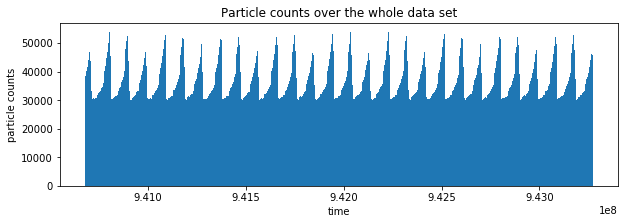

In [157]:

plt.hist(Data['time'],weights=Data['particle counts'], bins=5000)
#plt.yscale('log')
plt.xlabel('time')
plt.ylabel('particle counts')
plt.title('Particle counts over the whole data set')
plt.show()


Below we can see that there really is not a correlation of the particle counts to the solar phase

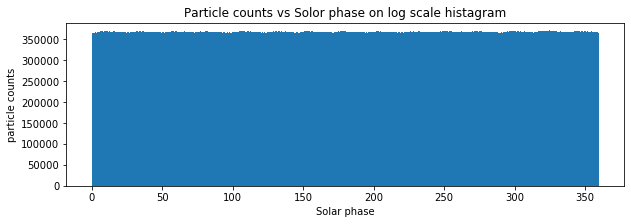

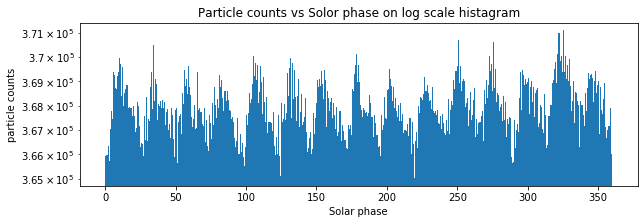

In [158]:
plt.hist(Data['Solar phase'],weights=Data['particle counts'], bins=500)
plt.xlabel('Solar phase')
plt.ylabel('particle counts')
plt.title('Particle counts vs Solor phase on log scale histagram')

#plt.yscale('log')
plt.show()
plt.hist(Data['Solar phase'],weights=Data['particle counts'], bins=500)
plt.xlabel('Solar phase')
plt.ylabel('particle counts')
plt.title('Particle counts vs Solor phase on log scale histagram')

plt.yscale('log')
plt.show()

Now when looking at the particle counts vs the earth phase we see a nice distribution that looks exponential. This is going to be how we make the background pdf 

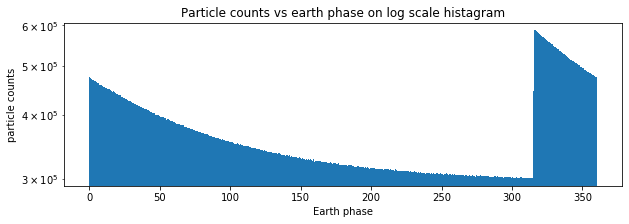

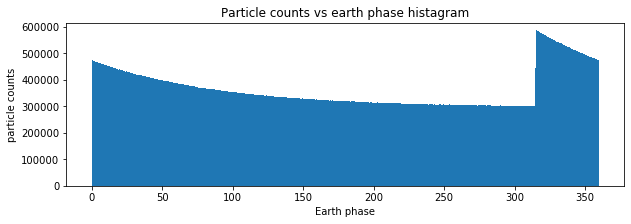

In [166]:
plt.hist(Data['Earth phase'],weights=Data['particle counts'], bins=500)
plt.yscale('log')
plt.ylabel('particle counts')
plt.xlabel('Earth phase')
plt.title('Particle counts vs earth phase on log scale histagram')
plt.show()

plt.hist(Data['Earth phase'],weights=Data['particle counts'], bins=500)
#plt.yscale('log')
plt.ylabel('particle counts')
plt.xlabel('Earth phase')
plt.title('Particle counts vs earth phase histagram')
plt.show()

Lets make sure that the phase changes constantly over time since we are going to want to find a time dependence for the phase on time

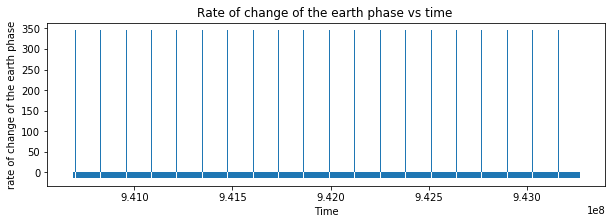

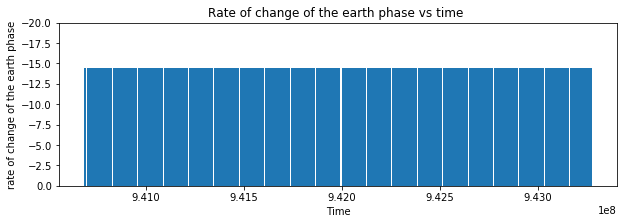

In [10]:
Diff = Data['Earth phase'].diff()
plt.ylabel('rate of change of the earth phase')
plt.xlabel('Time')
plt.title('Rate of change of the earth phase vs time ')
plt.hist(Data['time'],weights=Diff, bins=500)
plt.show()
Diff = Data['Earth phase'].diff()
plt.ylabel('rate of change of the earth phase')
plt.title('Rate of change of the earth phase vs time ')
plt.xlabel('Time')
plt.hist(Data['time'],weights=Diff, bins=500)
plt.ylim([0,-20])
plt.show()

Looking at the data we see signal contamination that has a dependency on the earths phase. Now to get a background we will find the dependency of the partial count to the earth’s phase. That will give us an average count that we can use to build a Poisson background distribution to then use to find significance of signals. Before that we need to make sure that we have enough data points at each phase to get an accurate mean, if not we will average over a few degrees, which will be an issue right at the jump of the particle count that we see at around 320 degrees in the earths phase in that range we will need to only look at a range that does not go across the particle count jump. Since we have 430 orbits in our data we do want average the mean over a small range, we will chose plus and minus 0.1 degrees for this range

2)
So then we expect the background to be a Poisson distributed since we have random independent events happening at a constant rate, textbook Poisson. We just need to find a mean for it. To find the mean for a phase we filter our data so we just have the measurement from he same earth phase and then mean the counts. We then use that mean to model out background. Now once we have a way to go from earth phase to mean we can easily go from time to mean since earth phase has a change vs time and we have a data frame with metadata that we can use to look up the earth phase and any given time. But we can also just look at the meta data and can pull out the earth phase at any time.

Given more time I would have found an analytical solution for the time dependence of the particle count which would have been a periodic decaying exponential, but pulling means form the background averaged over multiple days will give us a accurate background to use when searching for signals especially since it will allow us to adjust for shift over time of the time dependence by actually calculating it and not setting it from only a few orbits at the start of the experiment


3) now we can model the background data at any time let do it for a few times to show how close the model is to the data, we just look at data taken at the same earth phase plus or minuses 0.1 degrees. We particularly care about how well the tails fits the data which can be seen on the semi log graph. we expect to see a cut off for high particle counts since we are only looking at a few thousand data point

In [181]:
def backgroundmodelplotspread(n):
    #n=1099000

    D = Data[(Data["Earth phase"] < Data.at[n+15,'Earth phase'])]
    D = D[(D["Earth phase"] >= Data.at[n-15,'Earth phase'])]
    
    mu=D.mean()
    
    fig, ax = plt.subplots(1,1)
    x = np.arange(0,40,1)
    ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5,label = 'Model of background')
    plt.xlim([0,25])
    plt.hist(D['particle counts'], bins=np.arange(0,40,1), density=True,label =  'Background of the data')
    plt.yscale('log')
    plt.ylabel('Frequncy')
    plt.xlabel('Particle count')
    plt.title('Particle count frequency background at earth phase={0:1.6f} plus and minus 0.1 degrees on a semilog graph'.format(Data.at[n,'Earth phase']))
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(1,1)
    x = np.arange(0,40,1)
    ax.plot(x,stats.poisson.pmf(x,mu[3],loc=0), linewidth = 5, alpha = .5, label = 'Model of background')
    #plt.matplotlib.pyplot.step(x,stats.poisson.pmf(x,mu[3],loc=0))
    plt.hist(D['particle counts'], bins=np.arange(0,40,1), density=True,align='left',label = 'Background of the data')
    plt.xlim([0,25])
    plt.ylabel('Frequncy')
    plt.title('Particle count frequency background at earth phase ={0:1.6f} plus and minus 0.1 degrees'.format(Data.at[n,'Earth phase']))
    plt.xlabel('Particle count')
    plt.legend()
    plt.show()
    
    #print(len(D))

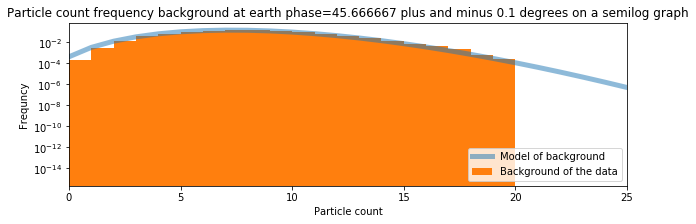

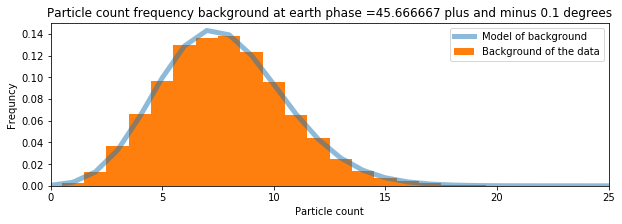

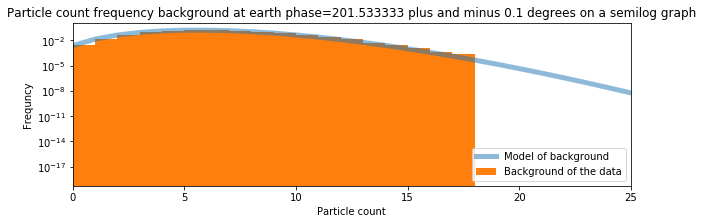

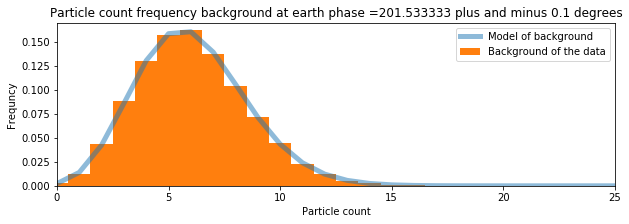

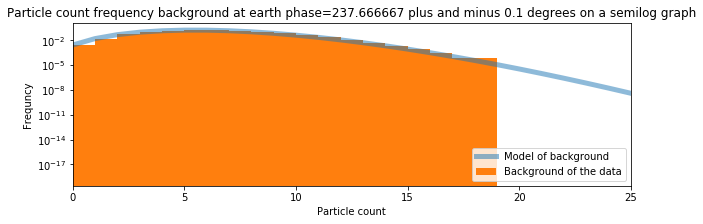

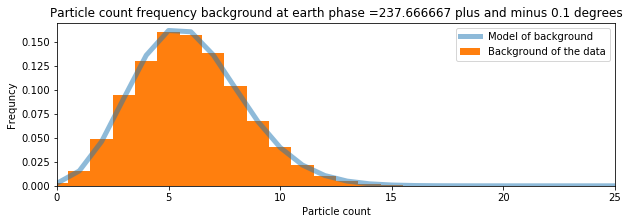

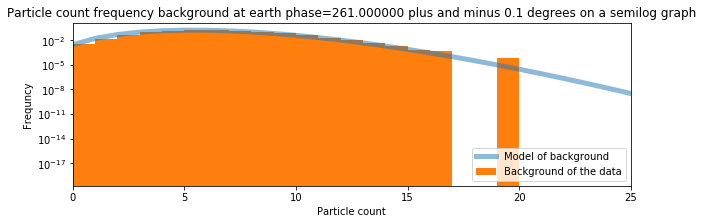

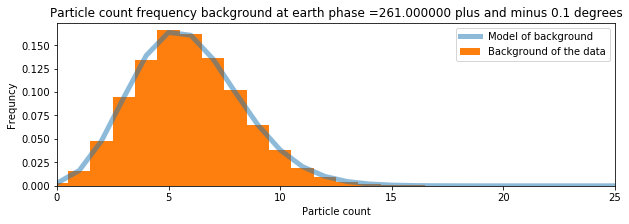

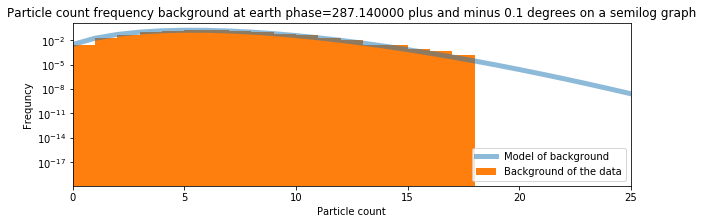

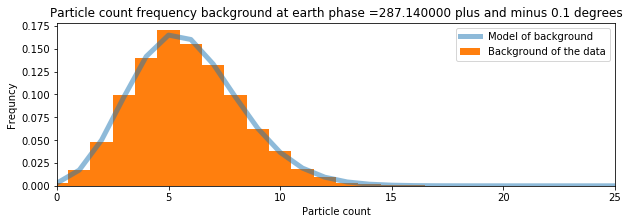

In [182]:
backgroundmodelplotspread(100)
backgroundmodelplotspread(239480)
backgroundmodelplotspread(190900)
backgroundmodelplotspread(32400)
backgroundmodelplotspread(900321)

Our model looks very good.


4) We will now calculate what a five sigma detection is at different times are, using our model background

In [17]:
def fiveSigTenthD(n):
    #n=1099000

    D = Data[(Data["Earth phase"] < Data.at[n+15,'Earth phase'])]
    D = D[(D["Earth phase"] >= Data.at[n-15,'Earth phase'])]
    
    mu=D.mean()
    p = stats.norm.cdf(5)
    s=scipy.stats.poisson.ppf(p,mu[3], loc=0)
    #print(s)
    return(s)

In [18]:
n=34100
print("At time = {1:1.0f} we need to see {0:1.0f} particle in a 100 milliseconds span".format(fiveSigTenthD(n),Data.at[n,'time']))
n=3410000
print("At time = {1:1.0f} we need to see {0:1.0f} particle in a 100 milliseconds span".format(fiveSigTenthD(n),Data.at[n,'time']))
n=3400
print("At time = {1:1.0f} we need to see {0:1.0f} particle in a 100 milliseconds span".format(fiveSigTenthD(n),Data.at[n,'time']))
n=39084
print("At time = {1:1.0f} we need to see {0:1.0f} particle in a 100 milliseconds span".format(fiveSigTenthD(n),Data.at[n,'time']))
n=988943
print("At time = {1:1.0f} we need to see {0:1.0f} particle in a 100 milliseconds span".format(fiveSigTenthD(n),Data.at[n,'time']))
n=4235993
print("At time = {1:1.0f} we need to see {0:1.0f} particle in a 100 milliseconds span".format(fiveSigTenthD(n),Data.at[n,'time']))


At time = 940683426 we need to see 21 particle in a 100 milliseconds span
At time = 941021016 we need to see 23 particle in a 100 milliseconds span
At time = 940680356 we need to see 24 particle in a 100 milliseconds span
At time = 940683924 we need to see 21 particle in a 100 milliseconds span
At time = 940778910 we need to see 22 particle in a 100 milliseconds span
At time = 941103615 we need to see 22 particle in a 100 milliseconds span


**Problem 2**



Now we are looking at a stack of simulated data of 10 images to find signals of a transient (a bright pixel that only show up in one image

1) Let’s look at the ten pictures

In [2]:
hf = h5py.File('images.h5', 'r')
print(hf.keys())
imageStack = np.array(hf.get('imagestack'))
image1 = np.array(hf.get('image1'))
image2 = np.array(hf.get('image2'))
hf.close()


<KeysViewHDF5 ['image1', 'imagestack']>


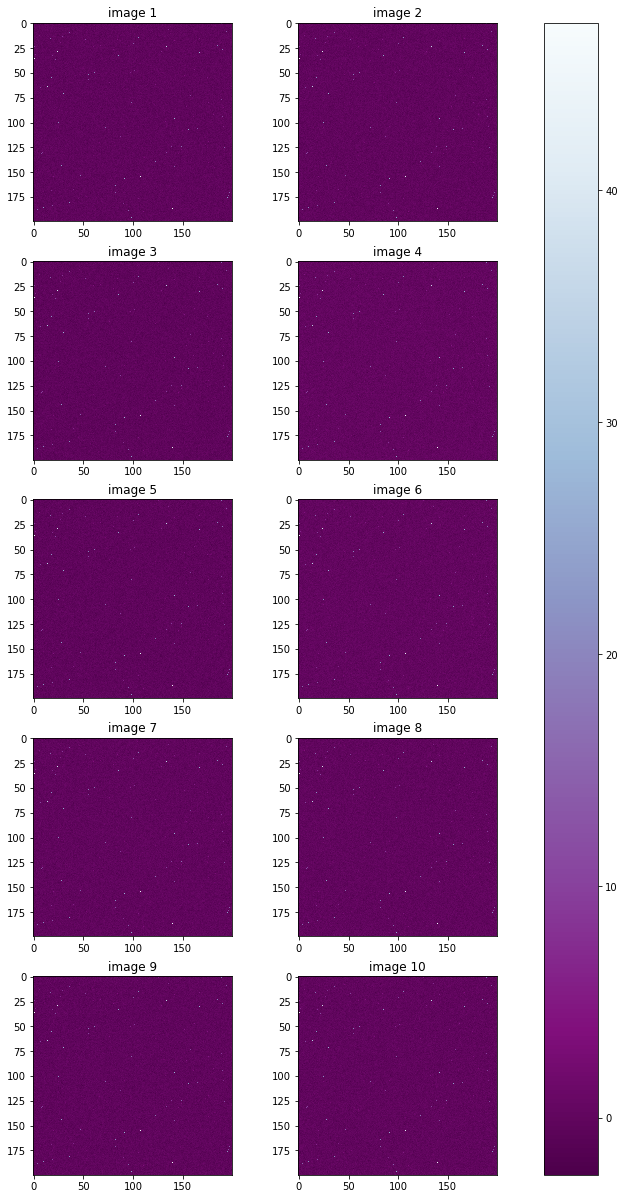

In [167]:
plt.rcParams["figure.figsize"] = (10,20)
plt.subplot(521)
plt.title("image 1")
plt.imshow(imageStack[:,:,0], cmap=plt.cm.BuPu_r)

plt.subplot(522)
plt.title("image 2")
plt.imshow(imageStack[:,:,1], cmap=plt.cm.BuPu_r)

plt.subplot(523)
plt.title("image 3")
plt.imshow(imageStack[:,:,2], cmap=plt.cm.BuPu_r)

plt.subplot(524)
plt.title("image 4")
plt.imshow(imageStack[:,:,3], cmap=plt.cm.BuPu_r)

plt.subplot(525)
plt.title("image 5")
plt.imshow(imageStack[:,:,4], cmap=plt.cm.BuPu_r)

plt.subplot(526)
plt.title("image 6")
plt.imshow(imageStack[:,:,5], cmap=plt.cm.BuPu_r)

plt.subplot(527)
plt.title("image 7")
plt.imshow(imageStack[:,:,6], cmap=plt.cm.BuPu_r)

plt.subplot(528)
plt.title("image 8")
plt.imshow(imageStack[:,:,7], cmap=plt.cm.BuPu_r)

plt.subplot(529)
plt.title("image 9")
plt.imshow(imageStack[:,:,8], cmap=plt.cm.BuPu_r)

plt.subplot(5,2,10)
plt.title("image 10")
plt.imshow(imageStack[:,:,9], cmap=plt.cm.BuPu_r)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

2)
So from the picture themselves we don’t see any obvious changes with time we do see spatial  differences with small bright points sprinkled through. Let’s take the difference between pixels between pairs of images to see what we get. Since we want to find a larger deference between images. 

In [123]:
difImage1 = image1-image2
difImage2 = image2-image3
difImage3 = image3-image4
difImage4 = image4-image5
difImage5 = image5-image6
difImage6 = image6-image7
difImage7 = image7-image8
difImage8 = image8-image9
difImage9 = image9-image10

In [172]:
diffAll = np.array([])
for x in range(200):
    diffAll = np.append(diffAll,difImage1[x])
    
for x in range(200):
    diffAll = np.append(diffAll,difImage2[x])
    
for x in range(200):
    diffAll = np.append(diffAll,difImage3[x])
    
for x in range(200):
    diffAll = np.append(diffAll,difImage4[x])
    
for x in range(200):
    diffAll = np.append(diffAll,difImage5[x])
    
for x in range(200):
    diffAll = np.append(diffAll,difImage6[x])
    
for x in range(200):
    diffAll = np.append(diffAll,difImage7[x])
    
for x in range(200):
    diffAll = np.append(diffAll,difImage8[x])
    
for x in range(200):
    diffAll = np.append(diffAll,difImage9[x])

Text(0.5, 1.0, 'Histogram of pixel different between consecutive images on a semi log scale')

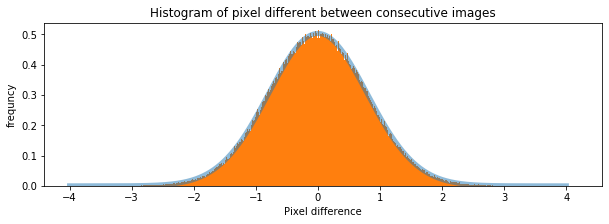

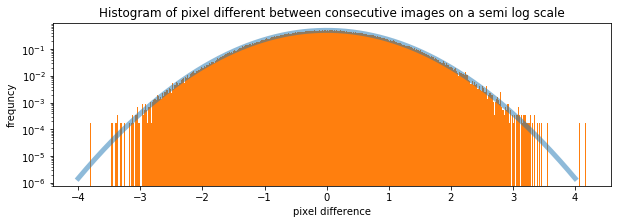

In [178]:
mean=np.mean(diffAll)
mu =np.sqrt(np.var(diffAll))
x = np.linspace(-4,4,1000)


fig, ax = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = (10,3)

ax.plot(x,stats.norm.pdf(x,loc=mean,scale = mu), linewidth = 5, alpha = .5)

plt.hist(diffAll, bins=500, density= True)
plt.xlabel('Pixel difference')
plt.ylabel('frequncy')
plt.title('Histogram of pixel different between consecutive images')


fig, ax = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = (10,3)

ax.plot(x,stats.norm.pdf(x,loc=mean,scale = mu), linewidth = 5, alpha = .5)

plt.hist(diffAll, bins=500, density= True)
plt.yscale('log')
plt.xlabel('pixel difference')
plt.ylabel('frequncy')
plt.title('Histogram of pixel different between consecutive images on a semi log scale')


We got a really nice Gaussian distribution that we can use as our background. 

4)
we will now try to find signals in this distribution
Now since we have a Gaussian this makes finding the significance of a signal to be really easy we take the difference from the mean of any value and divide by the standard derivation in math we have $\sigma = \frac{|X - mean|}{mu}$ we will do this first to narrow down the search but then we need to deal with the look elsewhere effect that will reduce the significance of any measurement.


In [139]:
sigma = abs(diffAll-mean)/mu

x = {'pixel diff' : diffAll, 'sigma': sigma}
DiffAll = pd.DataFrame(x)

In [175]:
DiffAll
transient  =DiffAll[DiffAll['sigma'] > 5]
# = transient[transient['pixel diff'] > 0]

In [176]:
transient 

,pixel diff,sigma
90348,4.168097,5.259068
201953,4.070322,5.135719


So we see two signal candidates now we want to apply a trials factor of 40000 since we are looking at images of 40000 pixels

In [184]:
p = (1-scipy.stats.norm.cdf(4.168097, loc=0, scale=mu))*200*200
print('We get a simga significance of {0:1.3f} for the first candidate'.format(stats.norm.ppf(1-p)))
p = (1-scipy.stats.norm.cdf(4.070322, loc=0, scale=mu))*200*200
print('We get a simga significance of {0:1.3f} for the secound candidate'.format(stats.norm.ppf(1-p)))

We get a simga significance of 2.758 for the first candidate
We get a simga significance of 2.534 for the secound candidate


After aplyig the trails factor we soo that we dont infact have a signifcat signal

4)
My lab partner and I have different pdf because we are looking for different kinds of signals, I was looking for a bright spot that only shows up for a signal image so my pdf comes from difference of images when my partner was looking for a dark point that mean that he would add up over the images instead of taking the different resulting in different pdfs